# Introduction

## In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

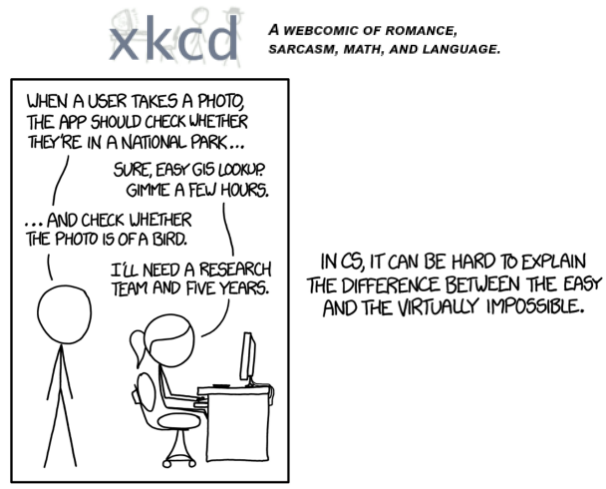

But today, we can do exactly that, in just a few minutes, using entirely free resources!

# Downloading requirements

In [1]:
#This helps widgets somehow
%matplotlib inline 

In [2]:
! pip install -Uq fastai fastbook duckduckgo_search ipywidgets

In [3]:
#hide
import fastbook
fastbook.setup_book()
from pathlib import Path

In [4]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# Preparing training- and validation set

## Variable definitions

In [23]:
model_name = "test"
img_amount = 50 #images pr. category
img_quality = 224 #image quality in pixels

prefix = "Image of "
category_types = ['cat', 'hat', 'bat']
suffix = ""

trainingFolder = Path.cwd().parent / 'Training-data'
modelFolder = Path.cwd().parent.parent / 'Trained-models'


c:\Users\Gamer\Documents\GitHub\VS-Code\Side-Projects\Trained-models


## Info for upcomming training

In [6]:
ttl_imgs = round(len(category_types)*img_amount)
epochs = round(ttl_imgs ** 0.225)
print(f'Toral images: {ttl_imgs}')
print(f'Expected epochs: {epochs}')

Toral images: 150
Expected epochs: 3


## Collecting images

In [7]:
from duckduckgo_search import DDGS
from fastcore.all import *
import shutil

print(trainingFolder)

# Clear the contents of the categories' directories if it already exists
if trainingFolder.exists():
    print(f"The '{trainingFolder}' dictionary already exists")
    shutil.rmtree(trainingFolder)
    print(f"Cleared the '{trainingFolder}' directory")

# Create the categories' directories and subdirectories, and download images
trainingFolder.mkdir(parents=True)
for o in category_types:
    dest = (trainingFolder/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f"{prefix}{o}{suffix}", max_images=img_amount)
    download_images(dest, urls=results)
    print(f"Created new folder for: '{prefix}{o}{suffix}', and downloaded the images")

if trainingFolder.exists():
    print('All folders have been created successfully')
else:
    print(f"Something fucked up. The directory: '{trainingFolder}' does not exist")

c:\Users\Gamer\Documents\GitHub\VS-Code\Side-Projects\Image-recognition\Training-data
The 'c:\Users\Gamer\Documents\GitHub\VS-Code\Side-Projects\Image-recognition\Training-data' dictionary already exists
Cleared the 'c:\Users\Gamer\Documents\GitHub\VS-Code\Side-Projects\Image-recognition\Training-data' directory
Created new folder for: 'Image of cat', and downloaded the images
Created new folder for: 'Image of hat', and downloaded the images
Created new folder for: 'Image of bat', and downloaded the images
All folders have been created successfully


## Unlinking failed images

In [8]:
fns = get_image_files(trainingFolder)

failed = verify_images(fns)
print(f'Failed images: {len(failed)}')

failed.map(Path.unlink)
print('Unlinking complete')

print(f'Successful images: {len(fns)} ready for training')

Failed images: 9
Unlinking complete
Successful images: 144 ready for training


In [9]:
categories = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(size=img_quality, method='squish'))

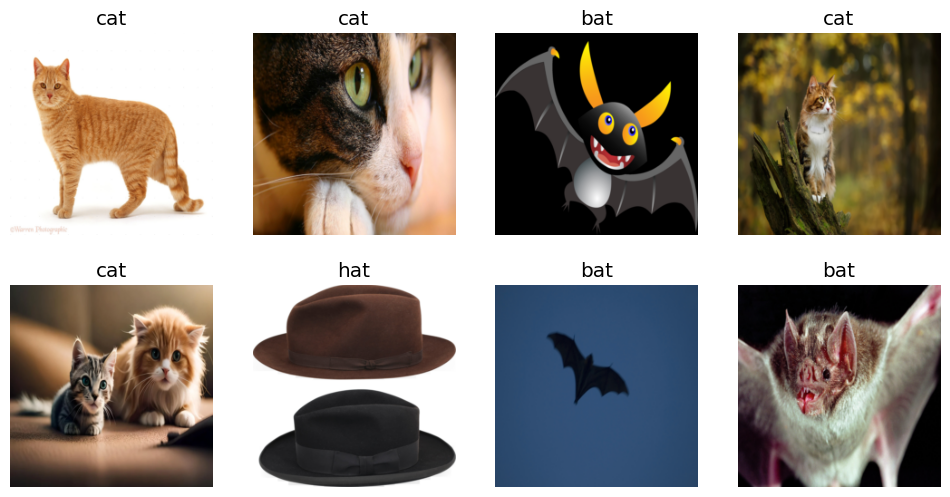

In [10]:
dls = categories.dataloaders(trainingFolder)
dls.valid.show_batch(max_n=8, nrows=2, unique=False)

## Non-augmented or resized image example

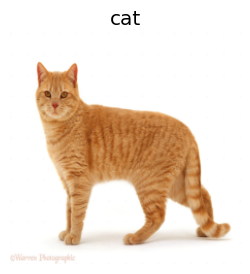

In [11]:
dls = categories.dataloaders(trainingFolder)
dls.valid.show_batch(max_n=1, nrows=1, unique=True)

## RandomResizedCrop examples

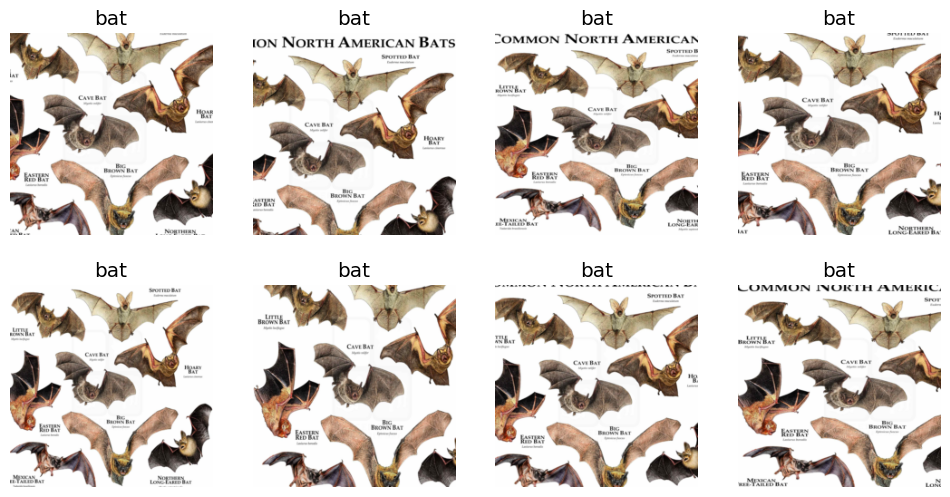

In [12]:
categories = categories.new(item_tfms=RandomResizedCrop(size=img_quality, min_scale=0.55))
dls = categories.dataloaders(trainingFolder)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## RandomResizedCrop & transform augmentation

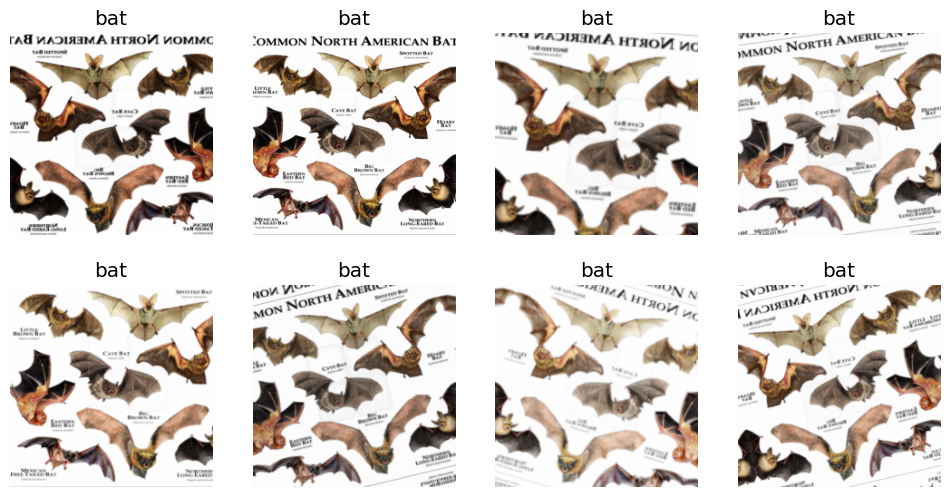

In [13]:
categories = categories.new(item_tfms=Resize(size=img_quality), 
                batch_tfms=[Flip(), Rotate(max_deg=18), Zoom(min_zoom=1.0, max_zoom=1.20), 
                Brightness(max_lighting=0.3), Contrast(max_lighting=0.25)])
dls = categories.dataloaders(trainingFolder)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Training

In [14]:
print(f'Training for: {epochs} epochs')
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(epochs)

Training for: 3 epochs


epoch,train_loss,valid_loss,error_rate,time
0,1.565782,0.995317,0.407407,00:13


c:\Users\Gamer\miniconda3\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,1.506859,0.796040,0.333333,00:14
1,1.420116,0.592420,0.259259,00:14
2,1.201921,0.513444,0.222222,00:14


# Measureing where the model fails to interpret images correctly

## Confusion matrix

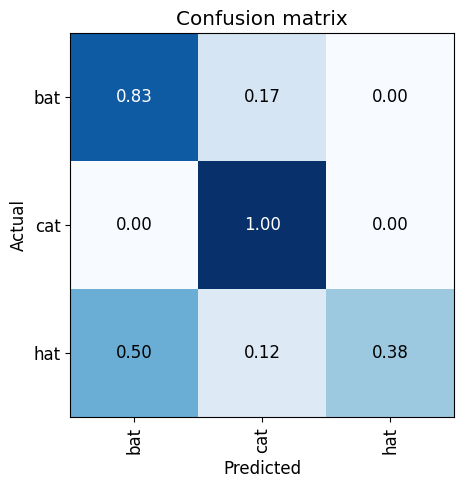

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

if len(category_types)<=50:
    interp.plot_confusion_matrix(normalize=True, norm_dec=2)

## Classifications with the highest loss

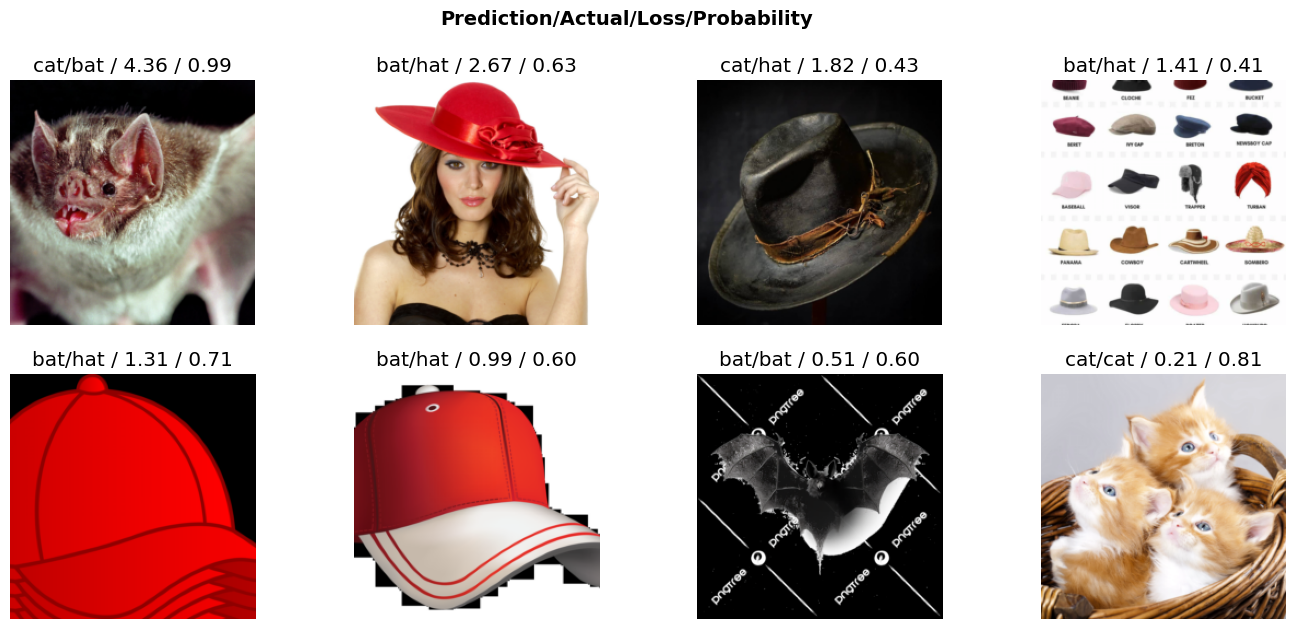

In [16]:
interp.plot_top_losses(8, nrows=2, figsize=(17, 7))

## Data-cleansing (optional)

In [17]:
cleaner = ImageClassifierCleaner(learn)
cleaner

c:\Users\Gamer\miniconda3\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [18]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,category in cleaner.change(): shutil.move(str(cleaner.fns[idx]), trainingFolder/category)

# Exporting our model

In [19]:
learn.export(modelFolder / f'{model_name}.pkl')
modelFolder.ls(file_exts=".pkl")

(#3) [Path('c:/Users/Gamer/Documents/GitHub/VS-Code/Side-Projects/Trained-models/animalClassifier.pkl'),Path('c:/Users/Gamer/Documents/GitHub/VS-Code/Side-Projects/Trained-models/league_champion_classifier.pkl'),Path('c:/Users/Gamer/Documents/GitHub/VS-Code/Side-Projects/Trained-models/test.pkl')]

# Testing our model with widgets

In [22]:
modelPath = modelFolder / f'{model_name}.pkl'
print(modelPath)

learn_inf = load_learner(modelPath)
learn_inf

c:\Users\Gamer\Documents\GitHub\VS-Code\Side-Projects\Trained-models\test.pkl


In [21]:
#hide_output
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(448,448))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred} | Probability: {probs[pred_idx]:.02f}'

btn_run.on_click(on_click_classify)

VBox([btn_upload, btn_run, out_pl, lbl_pred])